# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
np.random.seed(10)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

In [4]:
project_location = "./"
project_location = "e:/projects/stloc/"

# Load data

In [5]:
running_data = None
# running_data = '2celltypes'

## Spatial data

In [6]:
if running_data != '2celltypes':
    df_st = pd.read_csv(project_location + "data/merfish/merfishSpatial.csv", sep=" ")
else:
    df_st = pd.read_csv(project_location + "data/FaultSpatial.csv", sep=",")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
df_st.head()

,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,3.993327,20.596571,7.531108,13.294050,5.552498,9.445471,9.026888,23.262853,1.559171,0.000000,...,1,0,0,1,2,1,0,0,0,0
1,0.000000,0.000000,10.676513,0.606719,0.000000,43.836144,0.000000,8.300263,0.606719,1.437811,...,0,0,0,4,0,0,0,0,0,0
2,0.000000,0.000000,3.378244,1.219116,1.219116,7.910641,0.000000,1.529895,1.102756,0.000000,...,0,0,0,2,1,0,0,0,0,0
3,0.000000,0.000000,1.465245,0.732607,0.000000,2.323503,0.795436,0.732607,0.732607,0.000000,...,0,0,0,2,1,0,0,0,0,0
4,6.311896,7.574326,0.600405,0.600405,0.600405,0.600405,0.000000,0.600405,0.000000,0.000000,...,0,0,1,1,0,1,0,0,0,0


In [8]:
reference = pd.read_csv(project_location + "data/merfish/markerGene_for_merfish_data.csv")
reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


In [9]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
if running_data == '2celltypes':
    celltypes = ['Excitatory', 'Inhibitory']
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount'])
typeCountDf = df_st[celltypes]
typeCountDf

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0,2,0,1,1,0,1,0,0,1,2,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1279,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1280,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1281,1,2,0,1,2,0,0,0,0,0,0,0,0,0,0,0


In [10]:
print(cellcount)
zero = (cellcount==0).sum()
print('zero count is',zero)
len(celltypes)

      cellcount
0             9
1             5
2             4
3             3
4             4
...         ...
1278          4
1279          3
1280          5
1281          6
1282          2

[1283 rows x 1 columns]
zero count is cellcount    0
dtype: int64


16

## Single-cell data

In [11]:
if running_data != '2celltypes':
    df_sc = pd.read_csv(project_location + "data/merfish/merfishVisium.csv")
else:
    df_sc = pd.read_csv(project_location + "data/FaultSingleCell.csv")
df_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID,Ace2,...,Penk,Scg2,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.273327,0.0,0.003225,0.000000
1,b13e98f4-5c2b-4e96-985e-3e93aedc7221,1,Female,Naive,-0.24,-3746.226210,-3742.259347,Inhibitory,I-1,0.0,...,0.097542,0.0,0.000000,0.0,0.000000,0.016809,0.293094,0.0,0.006602,0.018258
2,d06cb29e-10ee-4bbc-b74e-90237999ef4b,1,Female,Naive,-0.24,-3742.897643,-3790.648737,Inhibitory,I-13,0.0,...,0.087302,0.0,0.063460,0.0,0.072791,0.000000,0.289555,0.0,0.000000,0.018325
3,12e2a165-57c7-4f37-96dd-23f6574af4ba,1,Female,Naive,-0.24,-3738.423005,-3773.259265,Inhibitory,I-19,0.0,...,0.098912,0.0,0.000000,0.0,0.048410,0.000000,0.247843,0.0,0.000000,0.008280
4,14a0f396-b13d-4d45-89a3-86c2047bf3f9,1,Female,Naive,-0.24,-3736.407620,-3895.590306,Pericytes,NaN,0.0,...,0.047054,0.0,0.178222,0.0,0.000000,0.000000,0.294404,0.0,0.000000,0.000000


In [12]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,b13e98f4-5c2b-4e96-985e-3e93aedc7221,1,Female,Naive,-0.24,-3746.226210,-3742.259347,Inhibitory,I-1
2,d06cb29e-10ee-4bbc-b74e-90237999ef4b,1,Female,Naive,-0.24,-3742.897643,-3790.648737,Inhibitory,I-13
3,12e2a165-57c7-4f37-96dd-23f6574af4ba,1,Female,Naive,-0.24,-3738.423005,-3773.259265,Inhibitory,I-19
4,14a0f396-b13d-4d45-89a3-86c2047bf3f9,1,Female,Naive,-0.24,-3736.407620,-3895.590306,Pericytes,NaN


In [13]:
df_sc.head()
cellTypeColumn= df_sc["Cell_class"].to_numpy()

# Tangram

In [14]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(6412, 155)
(1283, 155)


In [15]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [16]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:155 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:155 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [17]:
# adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

In [18]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf = adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.583, KL reg: 0.077
Score: 0.993, KL reg: 0.000
Score: 0.998, KL reg: 0.000
Score: 0.999, KL reg: 0.000
Score: 0.999, KL reg: 0.000


INFO:root:Saving results..


In [19]:
probabilityDf.shape
# probabilityDf.head()
print(cellcount.head())
print(type(cellcount.iloc[2,0]))
cellcount.iloc[1,0]

   cellcount
0          9
1          5
2          4
3          3
4          4
<class 'numpy.int64'>


5

# Probability analysis

In [33]:
Nrows = len(df_st)
Ncols = len(celltypes)
print(Nrows, Ncols)
probabilityDf["Cell_class"]=cellTypeColumn
# print(probabilityDf["Cell_class"])

df_prediction = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
tempDf = probabilityDf.copy()

for i in range(Nrows):
    tempDf= tempDf.sort_values(by=[str(i)], ascending=False)
    
    for  j in range(cellcount.iloc[i,0]):
        cellClass = tempDf.iloc[j]["Cell_class"]
        df_prediction.iloc[i][cellClass]+=1

df_prediction = df_prediction.astype(int)
deconvolveDf = df_prediction.copy()
df_prediction.head()

1283 16


,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0,2,0,1,1,0,1,0,0,1,2,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0


In [21]:
# np.argmax(probabilityDf.iloc[2])
# # probabilityDf.iloc[2,1247]

# Nrows = len(df_st)
# Ncols = len(celltypes)
# print(Nrows, Ncols)

# df_prediction = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
# for i in range(len(probabilityDf)):
#     spotNo = np.argmax(probabilityDf.iloc[i])
#     cellClass = obs_sc.loc[i,"Cell_class"]
#     df_prediction.loc[spotNo,cellClass] = df_prediction.loc[spotNo,cellClass] + 1


# df_prediction = df_prediction.astype(int)
# deconvolveDf = df_prediction.copy()
# df_prediction.shape

In [22]:
df_prediction.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,2,2,0,1,0,4,0,0,0,0,0,0,0,0,0,0
1,0,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0
4,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
for i in range(len(df_prediction)):
    deconvolveDf.iloc[i] = 100 * df_prediction.iloc[i]/df_prediction.iloc[i].sum()

In [36]:
print(deconvolveDf.head())
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)

   Astrocyte  Inhibitory  Pericytes  Ambiguous  Endothelial1  Excitatory  \
0        0.0   22.222222        0.0  11.111111     11.111111         0.0   
1        0.0    0.000000        0.0  20.000000      0.000000         0.0   
2        0.0    0.000000        0.0  25.000000      0.000000         0.0   
3        0.0    0.000000        0.0   0.000000      0.000000         0.0   
4        0.0    0.000000        0.0   0.000000     25.000000         0.0   

   ODImmature1  ODImmature2  Microglia  ODMature2  ODMature1  Endothelial3  \
0    11.111111          0.0        0.0  11.111111  22.222222     11.111111   
1     0.000000          0.0        0.0  80.000000   0.000000      0.000000   
2     0.000000          0.0        0.0  50.000000  25.000000      0.000000   
3     0.000000          0.0        0.0  66.666667  33.333333      0.000000   
4     0.000000          0.0       25.0  25.000000   0.000000     25.000000   

   ODMature3  ODMature4  Endothelial2  Ependymal  
0        0.0        0.0

Astrocyte       0
Inhibitory      0
Pericytes       0
Ambiguous       0
Endothelial1    0
Excitatory      0
ODImmature1     0
ODImmature2     0
Microglia       0
ODMature2       0
ODMature1       0
Endothelial3    0
ODMature3       0
ODMature4       0
Endothelial2    0
Ependymal       0
dtype: int64

In [37]:
# cellDict={}
# for  c in ['Astrocyte']:
#     uniqueCounts= (typeCountDf[c].unique())
#     uniqueCounts = np.sort(uniqueCounts)
#     for val in uniqueCounts:
#         cellDict[val]=[deconvolveDf.iloc[Index][c] for Index  in range(len(deconvolveDf))  if abs(typeCountDf.iloc[Index][c]-val)<0.0000001 ]
#     # print(cellDict[0])

#     fig, ax  = plt.subplots()
#     ax.boxplot(cellDict.values())
#     ax.set_xticklabels(cellDict.keys())

#     scatterDict={
#         "count": typeCountDf[c],
#         "fraction":deconvolveDf[c],
#     }
#     scatterDf=pd.DataFrame(scatterDict)   
#     ax1 = scatterDf.plot.scatter(x='count',
#                       y='fraction',
#                     )
#     # pdf = matplotlib.backends.backend_pdf.PdfPages("./output/merfish/tangram2c"+c+".pdf")
#     # pdf.savefig(ax)
#     # pdf.savefig(ax1)

# Spatial data exploration

In [38]:
cnt_ = 0
for j in range(deconvolveDf.shape[1]):
    for i in range(deconvolveDf.shape[0]):
        # if celltype-specific cellcount is zero and deconvolution percentage > threshold
        if typeCountDf.iloc[i,j] == 0 and deconvolveDf.iloc[i,j] > 25:
            print(cellcount.iloc[i][0], deconvolveDf.columns[j], deconvolveDf.iloc[i,j])
            cnt_ += 1
            if cnt_ > 10:
                break

3 Inhibitory 33.333333333333336
2 Inhibitory 50.0
2 Ambiguous 50.0
3 Ambiguous 33.333333333333336
3 Excitatory 33.333333333333336
2 Excitatory 50.0
2 Endothelial3 50.0


In [39]:
cellcount.value_counts()

cellcount
5            279
4            247
6            212
3            179
7            126
2             82
8             67
9             38
1             28
10            17
11             6
12             1
13             1
dtype: int64

# TANGRAM mispredictions

In [40]:
l = np.max(cellcount.values) + 1
count_misprediction = dict.fromkeys(celltypes)
for i in count_misprediction:
    count_misprediction[i] = dict.fromkeys(range(l))
    for j in count_misprediction[i]:
        count_misprediction[i][j] = [0, 0, dict.fromkeys(celltypes,0)]

for j in range(df_prediction.shape[1]):
    for i in range(df_prediction.shape[0]):
        actual_count = typeCountDf.iloc[i,j]
        predicted_count = df_prediction.iloc[i,j]
        tarr = count_misprediction[df_prediction.columns[j]][typeCountDf.iloc[i,j]]
        tarr[0] += 1
        if typeCountDf.iloc[i,j] != df_prediction.iloc[i,j]:
            tarr[1] += 1
            tarr[2] = {k: tarr[2].get(k, 0) + typeCountDf.iloc[i,:].to_dict().get(k, 0) \
                       for k in tarr[2].keys() | typeCountDf.iloc[i,:].to_dict().keys()}

Plotting for each celltype the number of spots with mispredictions

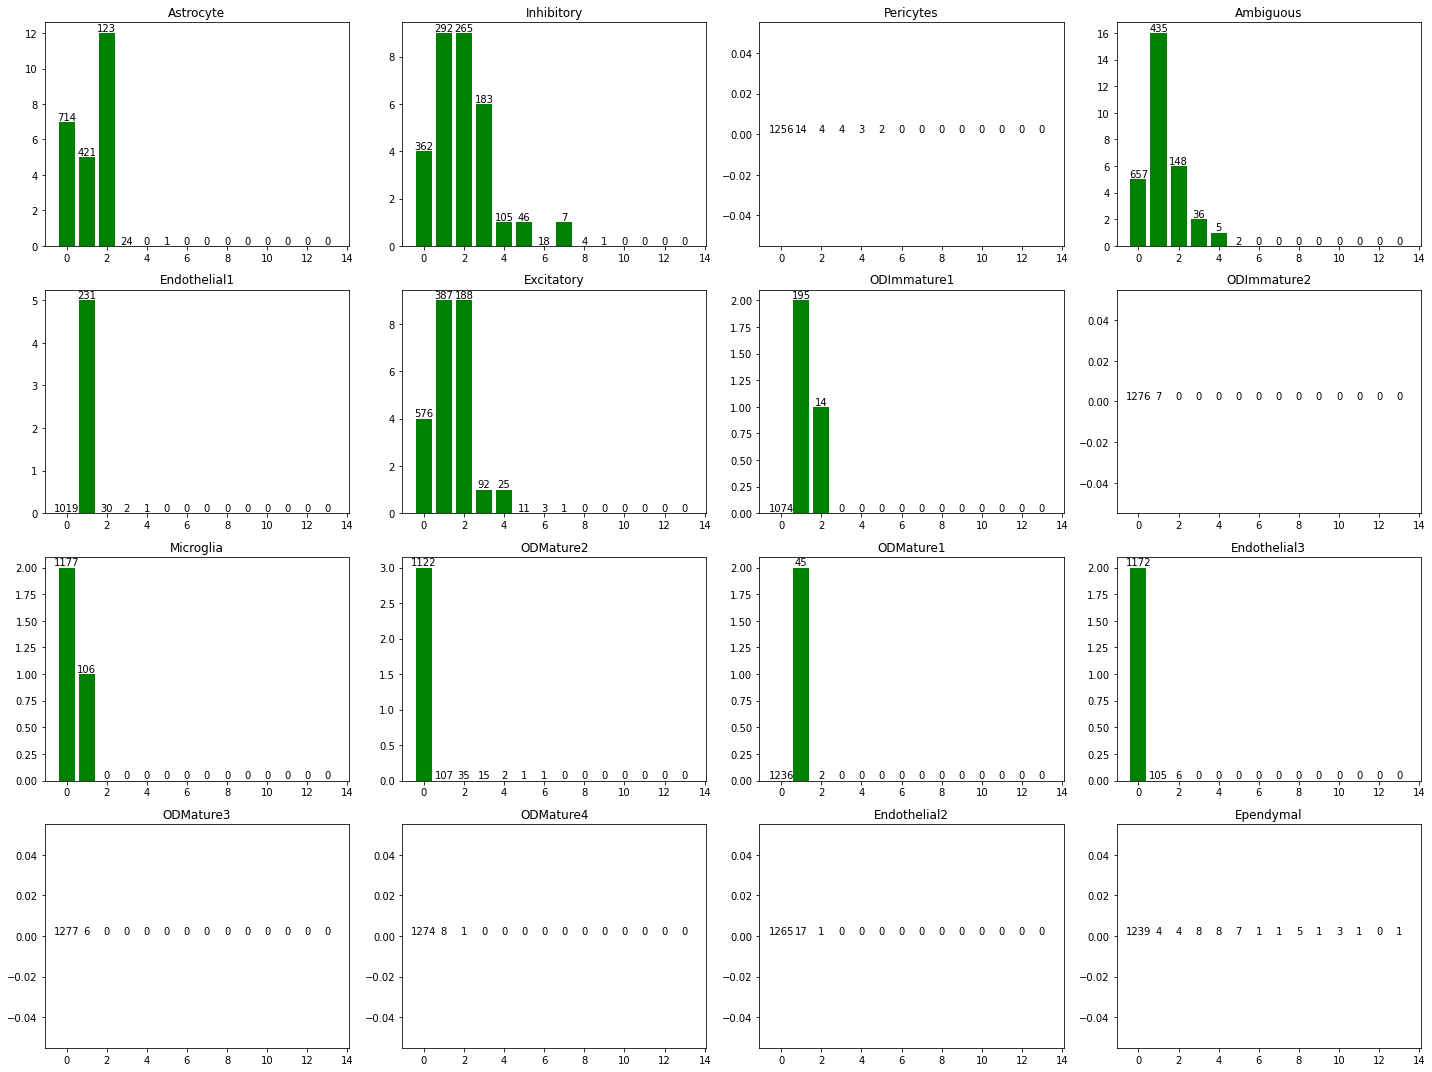

In [41]:
plt.rcParams['figure.figsize'] = [20,15]

for i, celltype in enumerate(celltypes):
    x = list(count_misprediction[celltype].keys())
    y = np.array(list(count_misprediction[celltype].values()))
    plt.subplot(4, 4, i+1)
    bar = plt.bar(x, y[:,1], width=0.8, color='g')
    for j, rect in enumerate(bar):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{y[j,0]:.0f}', ha='center', va='bottom')
    plt.title(celltype)
    plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

Plotting for each celltype the percentage of spots with mispredictions

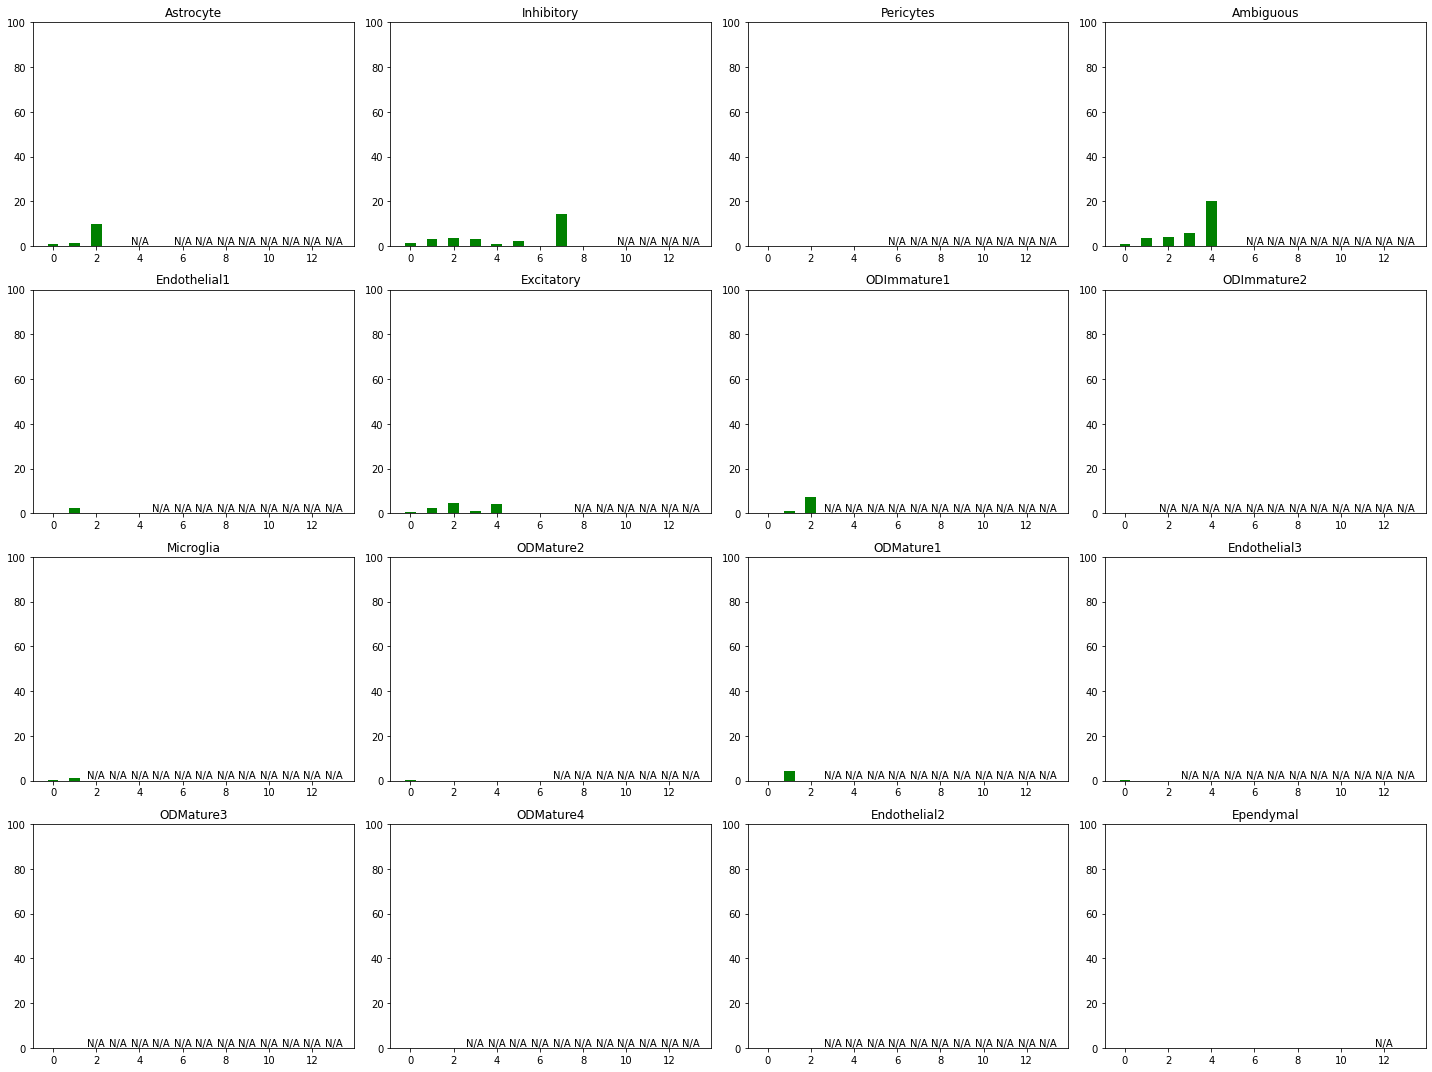

In [42]:
plt.rcParams['figure.figsize'] = [20,15]

for i, celltype in enumerate(celltypes):
    x = list(count_misprediction[celltype].keys())
    _y = np.array(list(count_misprediction[celltype].values()))[:,:2].astype(int)
    y = np.nan_to_num((_y[:,1] / _y[:,0]) * 100)
    # y = _y[:,1]
    plt.subplot(4, 4, i+1)
    bar = plt.bar(x, y, width=0.5, color='g')
    for j, rect in enumerate(bar):
        height = rect.get_height()
        if _y[j,0] == 0:
            plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'N/A', ha='center', va='bottom')
    plt.ylim((0,100))
    plt.title(celltype)
    plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

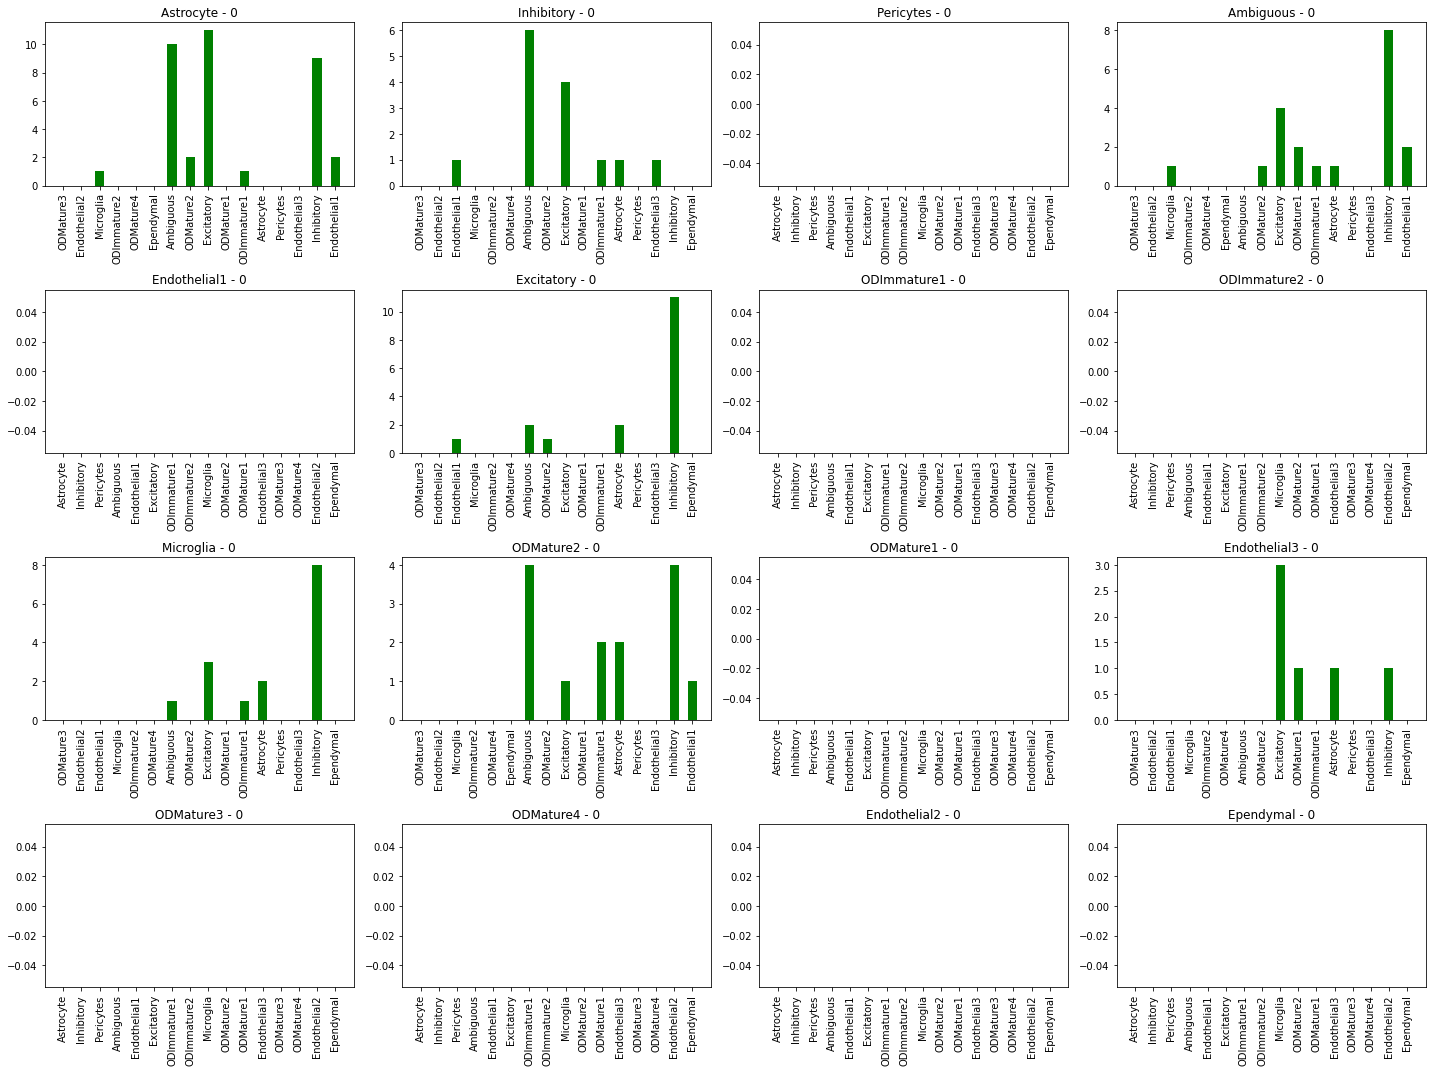

In [43]:
maxcellcount = len(count_misprediction[celltypes[0]].keys())
maxcellcount = 1

plt.rcParams['figure.figsize'] = [20, 15*maxcellcount]

j=0
for j in range(maxcellcount):
    for i, celltype in enumerate(celltypes):
        x = list(count_misprediction[celltype][j][2].keys())
        y = np.array(list(count_misprediction[celltype][j][2].values()))
        plt.subplot(4*maxcellcount, 4, j*16+i+1)
        bar = plt.bar(x, y, width=0.5, color='g')
        plt.xticks(rotation=90)
        # plt.ylim((0,100))
        plt.title(celltype + " - " + str(j))
        plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

In [44]:
celltype = 'Astrocyte'
np.array(list(count_misprediction[celltype][j][2].values()))

array([ 0,  0,  1,  0,  0,  0, 10,  2, 11,  0,  1,  0,  0,  0,  9,  2])